In [30]:
# PEMCAFE (ver. 0.8 30.Aug.2024)
# ANPP = delta AGC + litterfall 
# but BNPP have different methods = delta BGC + Soil_AR
# 1. delta BGC + Dbelow
# 2. delta BGC + Soil_AR

# combind single time version

import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

# Read the CSV file
df = pd.read_csv(r"Z:\RF for bamboo\Task C1\inputdataforPEMCAFE.csv")

# Define initial parameters
initial_params = [
    0.32,  # kLitter 
    0.63,  # LTurnoverR #Kobayashi et al., 2022
    0.21,  # BTurnoverR #Kobayashi et al., 2022
    0.18,  # CTurnoverR #Kobayashi et al., 2022
    0.18,  # StTurnoverR #Kobayashi et al., 2022
    0.9 / 8.1,  # RhTurnoverR #Kobayashi et al., 2022
    3.10 / 8.40,  # RoTurnoverR #Kobayashi et al., 2022
    3.87561968569648 / (1.57416255555556 + 3.87561968569648)  # Rratio_Litter_layer #Isagi et al., 1997
]

# Define bounds for parameters (all must be positive)
bounds = [
    (0, None),  # kLitter
    (0, None),  # LTurnoverR
    (0, None),  # BTurnoverR
    (0, None),  # CTurnoverR
    (0, None),  # StTurnoverR
    (0, None),  # RhTurnoverR
    (0, None),  # RoTurnoverR
    (0, 1)     # Rratio_Litter_layer
]

# Constraints: LTurnoverR > BTurnoverR > CTurnoverR and RoTurnoverR > RhTurnoverR
constraints = [
    {'type': 'ineq', 'fun': lambda params: params[1] - params[2]},  # LTurnoverR > BTurnoverR
    {'type': 'ineq', 'fun': lambda params: params[2] - params[3]},  # BTurnoverR > CTurnoverR
    {'type': 'ineq', 'fun': lambda params: params[6] - params[5]}   # RoTurnoverR > RhTurnoverR
]

# Is harvesting bamboo products or not?
# If yes, HBP = 1 else 0
#HBP = 1
HBP = 0

# Which method you would like to estimate BNPP
# If BNG + Dbelow, BNPPmethod=1 else 0 (BNG + Soil_AR)
BNPPmethod=1
#BNPPmethod=0


# Function to calculate values for each row
def calculate_values(row, prev_row, params):
    kLitter, LTurnoverR, BTurnoverR, CTurnoverR, StTurnoverR, RhTurnoverR, RoTurnoverR, Rratio_Litter_layer = params

    results = row.to_dict()  # Start with all original data

    results['LNP'] = row['Foliages'] - prev_row['Foliages'] if prev_row is not None else 0
    results['BNP'] = row['Branches'] - prev_row['Branches'] if prev_row is not None else 0
    results['CNP'] = row['Culms'] - prev_row['Culms'] if prev_row is not None else 0

    results['AGC'] = row['Foliages'] + row['Branches'] + row['Culms']

    results['StNP'] = 0.1955 * results['CNP']
    results['RhNP'] = 1.1162 * abs(results['LNP'])**0.7279 if results['LNP'] != 0 else 0
    results['RoNP'] = 0.9847 * results['RhNP']

    if prev_row is None:
        results['Stumps'] = row['Stumps']
        results['Rhizomes'] = row['Rhizomes']
        results['Roots'] = row['Roots']
    else:
        results['Stumps'] = prev_row['Stumps'] + results['StNP']
        results['Rhizomes'] = prev_row['Rhizomes'] + results['RhNP']
        results['Roots'] = prev_row['Roots'] + results['RoNP']

    results['BGC'] = results['Stumps'] + results['Rhizomes'] + results['Roots']
    results['Root_Shoot_Ratio'] = results['BGC'] / results['AGC'] if results['AGC'] != 0 else 0
    results['TC'] = results['AGC'] + results['BGC']

    results['LD'] = prev_row['Foliages'] * LTurnoverR if prev_row is not None else 0
    results['BD'] = prev_row['Branches'] * BTurnoverR if prev_row is not None else 0
    results['CD'] = prev_row['Culms'] * CTurnoverR if prev_row is not None else 0

    if HBP == 1:
        results['Litterfall'] = results['LD'] + results['BD']  # Exclude `CD`
    else:
        results['Litterfall'] = results['LD'] + results['BD'] + results['CD']  # Include `CD`

    results['ANPP'] = results['LNP'] + results['BNP'] + results['CNP'] + results['Litterfall']

    results['StD'] = prev_row['Stumps'] * StTurnoverR if prev_row is not None else 0
    results['RhD'] = prev_row['Rhizomes'] * RhTurnoverR if prev_row is not None else 0
    results['RoD'] = prev_row['Roots'] * RoTurnoverR if prev_row is not None else 0

    results['Dbelow'] = results['StD'] + results['RhD'] + results['RoD']

    results['Soil_AR'] = 0.000006 * results['BGC']**3.3249

    if BNPPmethod == 1:
        results['BNPP'] = results['StNP'] + results['RhNP'] + results['RoNP'] + results['Dbelow']
    else:
        results['BNPP'] = results['StNP'] + results['RhNP'] + results['RoNP'] + results['Soil_AR']    
    
    results['TNPP'] = results['ANPP'] + results['BNPP']

    if results['ANPP'] < 4.17:
        hr_anpp = 4.17
    elif results['ANPP'] > 11.8:
        hr_anpp = 11.8
    else:
        hr_anpp = results['ANPP']
    results['Soil_HR'] = 0.0071 * hr_anpp**3.0772 if results['ANPP'] != 0 else 0


    results['Foliages_AR'] = ((1.445 * 10**(-1) * math.exp(7.918*10**(-2)*row['AvgTemp'])) * 365*24 * (row['Foliages']/0.4544 * 1000000) /1000/1000/1000 * 12/44.01) 
    #from Isagi et a., 1997
    results['Branches_AR'] = 0.215/1.172 * ((1.445 * 10**(-1) * math.exp(7.918*10**(-2)*row['AvgTemp'])) * 365*24 * (row['Branches']/0.4815 * 1000000) /1000/1000/1000 * 12/44.01)
    #from Isagi et a., 1997; Wang et al., 2021
    results['Culms_AR'] = 0.085/1.172 * ((1.445 * 10**(-1) * math.exp(7.918*10**(-2)*row['AvgTemp'])) * 365*24 * (row['Culms']/0.4628 * 1000000) /1000/1000/1000 * 12/44.01)
    #from Isagi et a., 1997; Wang et al., 2021    
    results['Aboveground_AR'] = results['Foliages_AR'] + results['Branches_AR'] + results['Culms_AR']
    
    results['AR'] = results['Aboveground_AR'] + results['Soil_AR'] 
    
    results['SR'] = results['Soil_AR'] + results['Soil_HR']
    results['NEP_with_Aboveground_Detritus_Litter_layer_HR'] = results['TNPP'] - results['Soil_HR'] if results['TNPP'] != 0 else 0

    results['Litter_layer'] = (prev_row['Litter_layer'] + results['Litterfall']) * kLitter if prev_row is not None else row['Litter_layer']
    results['DLitter_layer'] = results['Litter_layer'] * kLitter
    results['Litter_layer_HR'] = results['Litter_layer'] * Rratio_Litter_layer
    #results['Aboveground_Detritus_HR'] = results['Litterfall'] - results['Litter_layer_HR'] - results['DLitter_layer'] if results['Litterfall'] != 0 else 0

    results['HR'] = results['Soil_HR'] + results['Litter_layer_HR'] #+ results['Aboveground_Detritus_HR']
    results['NEP'] = results['NEP_with_Aboveground_Detritus_Litter_layer_HR'] - results['Litter_layer_HR'] if results['TNPP'] != 0 else 0

    if prev_row is not None:
        results['SC'] = prev_row['SC'] + results['Dbelow'] - results['Soil_HR'] + results['DLitter_layer']
    else:
        results['SC'] = row['SC']
        
    results['dSC'] = results['SC'] - prev_row['SC'] if prev_row is not None else 0
    results['TEC'] = results['TC'] + results['Litter_layer'] + results['SC'] + row['Undergrowth']
    results['NEP_from_dTEC'] = results['TEC'] - prev_row['TEC'] if prev_row is not None else 0
    
    results['GPP'] = results['TNPP'] + results['AR'] 

    return results

# Function to run the model with given parameters
def run_model(params):
    results = []
    prev_row = None  # Initialize the previous row as None

    for i in range(len(df)):
        updated_values = calculate_values(df.iloc[i], prev_row, params)
        results.append(updated_values)
        prev_row = updated_values  # Update prev_row for the next iteration

    return pd.DataFrame(results)

# Objective function for optimization
def objective_function(params):
    results = run_model(params)
    rmse = np.sqrt(np.mean((results['NEP_from_dTEC'] - results['NEP'])**2))
    return rmse

# Step 1: Optimise the parameters using the initial run
result = minimize(objective_function, initial_params, method='Nelder-Mead')

# Step 2: Get the optimised parameters
optimised_params = result.x
print("Optimised parameters:", optimised_params)

# Step 3: Run the model with the optimised parameters to get final results
final_results = run_model(optimised_params)

# Step 4: Save the results
final_results.to_csv(r"Z:\RF for bamboo\Task C1\optimised_outputresultsforPEMCAFE.csv", index=False)
print("Optimisation complete. Results saved to 'optimised_outputresultsforPEMCAFE.csv'.")

Optimised parameters: [0.444249   0.5686026  0.18305827 0.16703727 0.18911645 0.10254921
 0.27269436 0.80676372]
Optimisation complete. Results saved to 'optimised_outputresultsforPEMCAFE.csv'.


In [31]:
# Monte Carol PEMCAFE

import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, sem

# Read the CSV file
df = pd.read_csv(r"Z:\RF for bamboo\Task C1\inputdataforPEMCAFE.csv")

# Define initial parameters
initial_params = [
    0.32,  # kLitter
    0.63,  # LTurnoverR
    0.21,  # BTurnoverR
    0.18,  # CTurnoverR
    0.18,  # StTurnoverR
    0.9 / 8.1,  # RhTurnoverR
    3.10 / 8.40,  # RoTurnoverR
    3.87561968569648 / (1.57416255555556 + 3.87561968569648)  # Rratio_Litter_layer
]

# Define bounds for parameters (all must be positive)
bounds = [
    (0, None),  # kLitter
    (0, None),  # LTurnoverR
    (0, None),  # BTurnoverR
    (0, None),  # CTurnoverR
    (0, None),  # StTurnoverR
    (0, None),  # RhTurnoverR
    (0, None),  # RoTurnoverR
    (0, 1)     # Rratio_Litter_layer
]

# Constraints: LTurnoverR > BTurnoverR > CTurnoverR and RoTurnoverR > RhTurnoverR
constraints = [
    {'type': 'ineq', 'fun': lambda params: params[1] - params[2]},  # LTurnoverR > BTurnoverR
    {'type': 'ineq', 'fun': lambda params: params[2] - params[3]},  # BTurnoverR > CTurnoverR
    {'type': 'ineq', 'fun': lambda params: params[6] - params[5]}   # RoTurnoverR > RhTurnoverR
]

# Is harvesting bamboo products or not?
# If yes, HBP = 1 else 0
#HBP = 1
HBP = 0

# Function to calculate values for each row
def calculate_values(row, prev_row, params):
    kLitter, LTurnoverR, BTurnoverR, CTurnoverR, StTurnoverR, RhTurnoverR, RoTurnoverR, Rratio_Litter_layer = params

    results = row.to_dict()  # Start with all original data

    results['LNP'] = row['Foliages'] - prev_row['Foliages'] if prev_row is not None else 0
    results['BNP'] = row['Branches'] - prev_row['Branches'] if prev_row is not None else 0
    results['CNP'] = row['Culms'] - prev_row['Culms'] if prev_row is not None else 0

    results['AGC'] = row['Foliages'] + row['Branches'] + row['Culms']

    results['StNP'] = 0.1955 * results['CNP']
    results['RhNP'] = 1.1162 * abs(results['LNP'])**0.7279 if results['LNP'] != 0 else 0
    results['RoNP'] = 0.9847 * results['RhNP']

    if prev_row is None:
        results['Stumps'] = row['Stumps']
        results['Rhizomes'] = row['Rhizomes']
        results['Roots'] = row['Roots']
    else:
        results['Stumps'] = prev_row['Stumps'] + results['StNP']
        results['Rhizomes'] = prev_row['Rhizomes'] + results['RhNP']
        results['Roots'] = prev_row['Roots'] + results['RoNP']

    results['BGC'] = results['Stumps'] + results['Rhizomes'] + results['Roots']
    results['Root_Shoot_Ratio'] = results['BGC'] / results['AGC'] if results['AGC'] != 0 else 0
    results['TC'] = results['AGC'] + results['BGC']

    results['LD'] = prev_row['Foliages'] * LTurnoverR if prev_row is not None else 0
    results['BD'] = prev_row['Branches'] * BTurnoverR if prev_row is not None else 0
    results['CD'] = prev_row['Culms'] * CTurnoverR if prev_row is not None else 0
    if HBP == 1:
        results['Litterfall'] = results['LD'] + results['BD']  # Exclude `CD`
    else:
        results['Litterfall'] = results['LD'] + results['BD'] + results['CD']  # Include `CD`

    results['ANPP'] = results['LNP'] + results['BNP'] + results['CNP'] + results['Litterfall']

    results['StD'] = prev_row['Stumps'] * StTurnoverR if prev_row is not None else 0
    results['RhD'] = prev_row['Rhizomes'] * RhTurnoverR if prev_row is not None else 0
    results['RoD'] = prev_row['Roots'] * RoTurnoverR if prev_row is not None else 0

    results['Dbelow'] = results['StD'] + results['RhD'] + results['RoD']

    results['Soil_AR'] = 0.000006 * results['BGC']**3.3249
    
    if BNPPmethod == 1:
        results['BNPP'] = results['StNP'] + results['RhNP'] + results['RoNP'] + results['Dbelow']
    else:
        results['BNPP'] = results['StNP'] + results['RhNP'] + results['RoNP'] + results['Soil_AR']    
    results['TNPP'] = results['ANPP'] + results['BNPP']

    if results['ANPP'] < 4.17:
        hr_anpp = 4.17
    elif results['ANPP'] > 11.8:
        hr_anpp = 11.8
    else:
        hr_anpp = results['ANPP']
    results['Soil_HR'] = 0.0071 * hr_anpp**3.0772 if results['ANPP'] != 0 else 0


    results['Foliages_AR'] = ((1.445 * 10**(-1) * math.exp(7.918*10**(-2)*row['AvgTemp'])) * 365*24 * (row['Foliages']/0.4544 * 1000000) /1000/1000/1000 * 12/44.01) 
    #from Isagi et a., 1997
    results['Branches_AR'] = 0.215/1.172 * ((1.445 * 10**(-1) * math.exp(7.918*10**(-2)*row['AvgTemp'])) * 365*24 * (row['Branches']/0.4815 * 1000000) /1000/1000/1000 * 12/44.01)
    #from Isagi et a., 1997; Wang et al., 2021
    results['Culms_AR'] = 0.085/1.172 * ((1.445 * 10**(-1) * math.exp(7.918*10**(-2)*row['AvgTemp'])) * 365*24 * (row['Culms']/0.4628 * 1000000) /1000/1000/1000 * 12/44.01)
    #from Isagi et a., 1997; Wang et al., 2021    
    results['Aboveground_AR'] = results['Foliages_AR'] + results['Branches_AR'] + results['Culms_AR']
    
    results['AR'] = results['Aboveground_AR'] + results['Soil_AR'] 
    
    results['SR'] = results['Soil_AR'] + results['Soil_HR']
    results['NEP_with_Aboveground_Detritus_Litter_layer_HR'] = results['TNPP'] - results['Soil_HR'] if results['TNPP'] != 0 else 0

    results['Litter_layer'] = (prev_row['Litter_layer'] + results['Litterfall']) * kLitter if prev_row is not None else row['Litter_layer']
    results['DLitter_layer'] = results['Litter_layer'] * kLitter
    results['Litter_layer_HR'] = results['Litter_layer'] * Rratio_Litter_layer
    #results['Aboveground_Detritus_HR'] = results['Litterfall'] - results['Litter_layer_HR'] - results['DLitter_layer'] if results['Litterfall'] != 0 else 0

    results['HR'] = results['Soil_HR'] + results['Litter_layer_HR'] #+ results['Aboveground_Detritus_HR']
    results['NEP'] = results['NEP_with_Aboveground_Detritus_Litter_layer_HR'] - results['Litter_layer_HR'] if results['TNPP'] != 0 else 0

    if prev_row is not None:
        results['SC'] = prev_row['SC'] + results['Dbelow'] - results['Soil_HR'] + results['DLitter_layer']
    else:
        results['SC'] = row['SC']
        
    results['dSC'] = results['SC'] - prev_row['SC'] if prev_row is not None else 0
    results['TEC'] = results['TC'] + results['Litter_layer'] + results['SC'] + row['Undergrowth']
    results['NEP_from_dTEC'] = results['TEC'] - prev_row['TEC'] if prev_row is not None else 0
    
    results['GPP'] = results['TNPP'] + results['AR'] 

    return results

# Function to run the model with given parameters
def run_model(params):
    results = []
    prev_row = None  # Initialize the previous row as None

    for i in range(len(df)):
        updated_values = calculate_values(df.iloc[i], prev_row, params)
        results.append(updated_values)
        prev_row = updated_values  # Update prev_row for the next iteration

    return pd.DataFrame(results)

# Objective function for optimization
def objective_function(params):
    results = run_model(params)
    rmse = np.sqrt(np.mean((results['NEP_from_dTEC'] - results['NEP'])**2))
    return rmse

# Step 1: Optimise the parameters using the initial run
result = minimize(objective_function, initial_params, method='Nelder-Mead')

# Step 2: Get the optimised parameters
optimised_params = result.x
print("Optimised parameters:", optimised_params)

# Step 3: Define random effects for Monte Carlo simulation
def monte_carlo_simulation(num_simulations=10000, std_dev=1.5):
    monte_carlo_results = []
    for _ in range(num_simulations):
        random_params = [norm(loc=param, scale=std_dev).rvs() for param in optimised_params]
        results = run_model(random_params)
        monte_carlo_results.append(results)
    return monte_carlo_results

# Run Monte Carlo simulation
monte_carlo_results = monte_carlo_simulation()

# Convert the results to a DataFrame for analysis
def flatten_results(results):
    """Flatten a list of DataFrames into a single DataFrame with MultiIndex."""
    combined_results = pd.concat(results, keys=range(len(results)), names=['Simulation', 'Index'])
    return combined_results.reset_index(level='Simulation', drop=True)

combined_results = flatten_results(monte_carlo_results)

# Calculate 85% confidence intervals for each cell
def calculate_confidence_intervals(df, num_simulations, confidence=0.85):
    ci_results = {}
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64]:
            mean = df[column].groupby(df.index).mean()
            conf_int = df[column].groupby(df.index).apply(lambda x: norm.interval(confidence, loc=x.mean(), scale=sem(x)))
            ci_results[column] = pd.DataFrame(list(conf_int), index=mean.index, columns=['Lower CI', 'Upper CI'])
    return pd.concat(ci_results, axis=1)

confidence_intervals = calculate_confidence_intervals(combined_results, num_simulations=len(monte_carlo_results))

# Save confidence intervals to a CSV file
confidence_intervals.to_csv(r"Z:\RF for bamboo\Task C1\monte_carlo_confidence_intervals.csv")
print("Monte Carlo simulation complete. Confidence intervals saved to 'monte_carlo_confidence_intervals.csv'.")

# Save one of the Monte Carlo results as an example
example_results = monte_carlo_results[0]
example_results.to_csv(r"Z:\RF for bamboo\Task C1\monte_carlo_example_results.csv", index=False)
print("Example results saved to 'monte_carlo_example_results.csv'.")

Optimised parameters: [0.444249   0.5686026  0.18305827 0.16703727 0.18911645 0.10254921
 0.27269436 0.80676372]
Monte Carlo simulation complete. Confidence intervals saved to 'monte_carlo_confidence_intervals.csv'.
Example results saved to 'monte_carlo_example_results.csv'.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


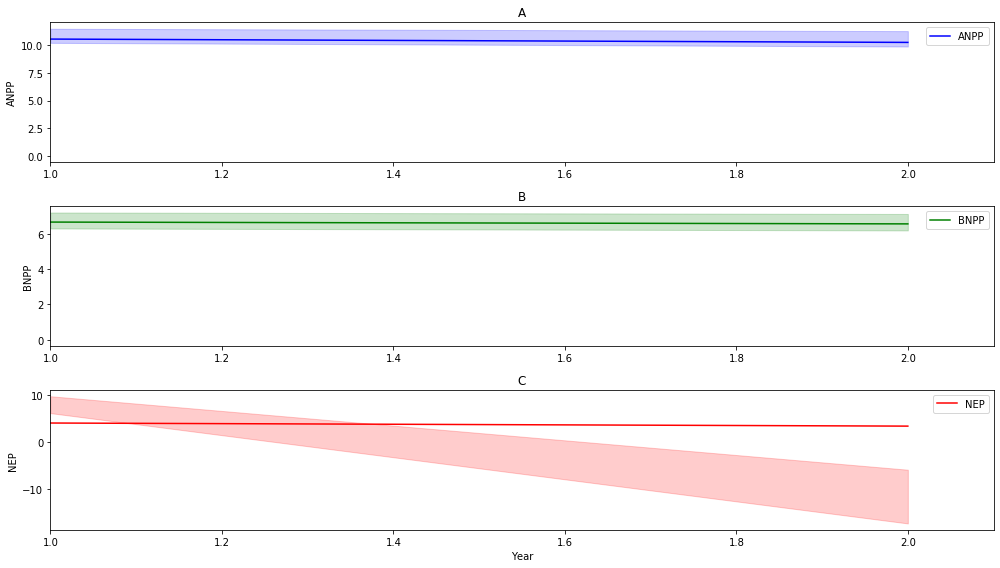

In [32]:
## Visualisation
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the save path
save_path = r'Z:\RF for bamboo\Task C1\\'

# Load the data from the provided CSV files
output_data = pd.read_csv(r'Z:\RF for bamboo\Task C1\optimised_outputresultsforPEMCAFE.csv')
ci_data = pd.read_csv(r'Z:\RF for bamboo\Task C1\monte_carlo_confidence_intervals.csv', header=[0, 1], index_col=0)

# Extract relevant data
years = output_data['t'] # # Adjust years to start from 1
anpp = output_data['ANPP']
bnpp = output_data['BNPP']
nep = output_data['NEP']

# Extract confidence intervals
anpp_upper = ci_data['ANPP',"Upper CI"]
anpp_lower = ci_data['ANPP',"Lower CI"]
bnpp_upper = ci_data['BNPP',"Upper CI"]
bnpp_lower = ci_data['BNPP',"Lower CI"]
nep_upper = ci_data['NEP',"Upper CI"]
nep_lower = ci_data['NEP',"Lower CI"]

# Plotting the data and saving
plt.figure(figsize=(14, 8))

# Plot ANPP
plt.subplot(3, 1, 1)
plt.plot(years, anpp, label='ANPP', color='blue')
plt.fill_between(years, anpp_lower, anpp_upper, color='blue', alpha=0.2)
plt.title('A')
plt.ylabel('ANPP')
plt.legend()
plt.xlim(left=1)  # Set x-axis to start from 1

# Plot BNPP
plt.subplot(3, 1, 2)
plt.plot(years, bnpp, label='BNPP', color='green')
plt.fill_between(years, bnpp_lower, bnpp_upper, color='green', alpha=0.2)
plt.title('B')
plt.ylabel('BNPP')
plt.legend()
plt.xlim(left=1)  # Set x-axis to start from 1

# Plot NEP
plt.subplot(3, 1, 3)
plt.plot(years, nep, label='NEP', color='red')
plt.fill_between(years, nep_lower, nep_upper, color='red', alpha=0.2)
plt.title('C')
plt.ylabel('NEP')
plt.xlabel('Year')
plt.legend()
plt.xlim(left=1)  # Set x-axis to start from 1

plt.tight_layout()

# Save the plot
plot_filename = os.path.join(save_path, 'ANPP_BNPP_NEP_vs_Year.png')
plt.savefig(plot_filename, dpi=1200)

plt.show()


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Optimised parameters: [0.4343966  0.64856772 0.18199963 0.14259139 0.16261279 0.13181628
 0.2896937  0.86767056]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1996: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


Monte Carlo simulation complete. Confidence intervals saved to 'monte_carlo_confidence_intervals.csv'.
Example results saved to 'monte_carlo_example_results.csv'.
Columns LNP_Lower CI and/or LNP_Upper CI not found in confidence intervals DataFrame


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:221: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\RF for bamboo\\Task C1\\plots\\LNP_confidence_intervals.png'

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


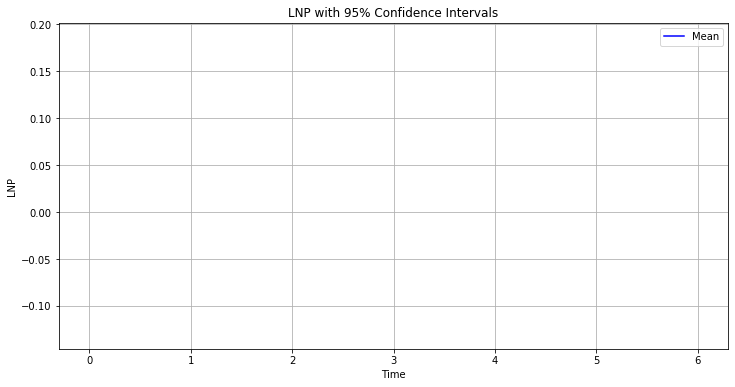

In [3]:
# Visualisation
###### not yet finish

import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import norm, sem
import matplotlib.pyplot as plt
import matplotlib as mpl

# Read the CSV file
df = pd.read_csv(r"Z:\RF for bamboo\Task C1\inputdataforPEMCAFE.csv")

# Define initial parameters
initial_params = [
    0.32,  # kLitter
    0.63,  # LTurnoverR
    0.21,  # BTurnoverR
    0.18,  # CTurnoverR
    0.18,  # StTurnoverR
    0.9 / 8.1,  # RhTurnoverR
    3.10 / 8.40,  # RoTurnoverR
    3.87561968569648 / (1.57416255555556 + 3.87561968569648)  # Rratio_Litter_layer
]

# Define bounds for parameters (all must be positive)
bounds = [
    (0, None),  # kLitter
    (0, None),  # LTurnoverR
    (0, None),  # BTurnoverR
    (0, None),  # CTurnoverR
    (0, None),  # StTurnoverR
    (0, None),  # RhTurnoverR
    (0, None),  # RoTurnoverR
    (0, 1)     # Rratio_Litter_layer
]

# Constraints: LTurnoverR > BTurnoverR > CTurnoverR and RoTurnoverR > RhTurnoverR
constraints = [
    {'type': 'ineq', 'fun': lambda params: params[1] - params[2]},  # LTurnoverR > BTurnoverR
    {'type': 'ineq', 'fun': lambda params: params[2] - params[3]},  # BTurnoverR > CTurnoverR
    {'type': 'ineq', 'fun': lambda params: params[6] - params[5]}   # RoTurnoverR > RhTurnoverR
]

# Function to calculate values for each row
def calculate_values(row, prev_row, params):
    kLitter, LTurnoverR, BTurnoverR, CTurnoverR, StTurnoverR, RhTurnoverR, RoTurnoverR, Rratio_Litter_layer = params

    results = row.to_dict()  # Start with all original data

    results['LNP'] = row['Foliages'] - prev_row['Foliages'] if prev_row is not None else 0
    results['BNP'] = row['Branches'] - prev_row['Branches'] if prev_row is not None else 0
    results['CNP'] = row['Culms'] - prev_row['Culms'] if prev_row is not None else 0

    results['AGC'] = row['Foliages'] + row['Branches'] + row['Culms']

    results['StNP'] = 0.1955 * results['CNP']
    results['RhNP'] = 1.1162 * abs(results['LNP'])**0.7279 if results['LNP'] != 0 else 0
    results['RoNP'] = 0.9847 * results['RhNP']

    if prev_row is None:
        results['Stumps'] = row['Stumps']
        results['Rhizomes'] = row['Rhizomes']
        results['Roots'] = row['Roots']
    else:
        results['Stumps'] = prev_row['Stumps'] + results['StNP']
        results['Rhizomes'] = prev_row['Rhizomes'] + results['RhNP']
        results['Roots'] = prev_row['Roots'] + results['RoNP']

    results['BGC'] = results['Stumps'] + results['Rhizomes'] + results['Roots']
    results['Root_Shoot_Ratio'] = results['BGC'] / results['AGC'] if results['AGC'] != 0 else 0
    results['TC'] = results['AGC'] + results['BGC']

    results['LD'] = prev_row['Foliages'] * LTurnoverR if prev_row is not None else 0
    results['BD'] = prev_row['Branches'] * BTurnoverR if prev_row is not None else 0
    results['CD'] = prev_row['Culms'] * CTurnoverR if prev_row is not None else 0
    results['Litterfall'] = results['LD'] + results['BD'] + results['CD']

    results['ANPP'] = results['LNP'] + results['BNP'] + results['CNP'] + results['Litterfall']

    results['StD'] = prev_row['Stumps'] * StTurnoverR if prev_row is not None else 0
    results['RhD'] = prev_row['Rhizomes'] * RhTurnoverR if prev_row is not None else 0
    results['RoD'] = prev_row['Roots'] * RoTurnoverR if prev_row is not None else 0

    results['Dbelow'] = results['StD'] + results['RhD'] + results['RoD']
    results['BNPP'] = results['StNP'] + results['RhNP'] + results['RoNP'] + results['Dbelow']
    results['TNPP'] = results['ANPP'] + results['BNPP']

    if results['ANPP'] < 4.17:
        hr_anpp = 4.17
    elif results['ANPP'] > 11.8:
        hr_anpp = 11.8
    else:
        hr_anpp = results['ANPP']
    results['Soil_HR'] = 0.0071 * hr_anpp**3.0772 if results['ANPP'] != 0 else 0

    results['Soil_AR'] = 0.000006 * results['BGC']**3.3249
    results['SR'] = results['Soil_AR'] + results['Soil_HR']
    results['NEP_with_Aboveground_Detritus_Litter_layer_HR'] = results['TNPP'] - results['Soil_HR'] if results['TNPP'] != 0 else 0

    results['Litter_layer'] = (prev_row['Litter_layer'] + results['Litterfall']) * kLitter if prev_row is not None else row['Litter_layer']
    results['DLitter_layer'] = results['Litter_layer'] * kLitter
    results['Litter_layer_HR'] = results['Litter_layer'] * Rratio_Litter_layer
    #results['Aboveground_Detritus_HR'] = results['Litterfall'] - results['Litter_layer_HR'] - results['DLitter_layer'] if results['Litterfall'] != 0 else 0

    results['HR'] = results['Soil_HR'] + results['Litter_layer_HR'] #+ results['Aboveground_Detritus_HR']
    results['NEP'] = results['NEP_with_Aboveground_Detritus_Litter_layer_HR'] - results['Litter_layer_HR'] if results['TNPP'] != 0 else 0

    if prev_row is not None:
        results['SC'] = prev_row['SC'] + results['Dbelow'] - results['Soil_HR'] + results['DLitter_layer']
    else:
        results['SC'] = row['SC']
        
    results['dSC'] = results['SC'] - prev_row['SC'] if prev_row is not None else 0
    results['TEC'] = results['TC'] + results['Litter_layer'] + results['SC'] + row['Undergrowth']
    results['NEP_from_dTEC'] = results['TEC'] - prev_row['TEC'] if prev_row is not None else 0

    return results

# Function to run the model with given parameters
def run_model(params):
    results = []
    prev_row = None  # Initialize the previous row as None

    for i in range(len(df)):
        updated_values = calculate_values(df.iloc[i], prev_row, params)
        results.append(updated_values)
        prev_row = updated_values  # Update prev_row for the next iteration

    return pd.DataFrame(results)

# Objective function for optimization
def objective_function(params):
    results = run_model(params)
    rmse = np.sqrt(np.mean((results['NEP_from_dTEC'] - results['NEP'])**2))
    return rmse

# Step 1: Optimise the parameters using the initial run
result = minimize(objective_function, initial_params, method='Nelder-Mead')

# Step 2: Get the optimised parameters
optimised_params = result.x
print("Optimised parameters:", optimised_params)

# Step 3: Define random effects for Monte Carlo simulation
def monte_carlo_simulation(num_simulations=10000, std_dev=0.1):
    monte_carlo_results = []
    for _ in range(num_simulations):
        random_params = [norm(loc=param, scale=std_dev).rvs() for param in optimised_params]
        results = run_model(random_params)
        monte_carlo_results.append(results)
    return monte_carlo_results

# Run Monte Carlo simulation
monte_carlo_results = monte_carlo_simulation()

# Convert the results to a DataFrame for analysis
def flatten_results(results):
    """Flatten a list of DataFrames into a single DataFrame with MultiIndex."""
    combined_results = pd.concat(results, keys=range(len(results)), names=['Simulation', 'Index'])
    return combined_results.reset_index(level='Simulation', drop=True)

combined_results = flatten_results(monte_carlo_results)

# Calculate 95% confidence intervals for each cell
def calculate_confidence_intervals(df, num_simulations, confidence=0.95):
    ci_results = {}
    for column in df.columns:
        if df[column].dtype in [np.float64, np.int64]:
            try:
                # Calculate mean and confidence intervals
                mean = df[column].groupby(df.index).mean()
                sem = lambda x: stats.sem(x, ddof=0)  # Standard error of the mean
                conf_int = df[column].groupby(df.index).apply(lambda x: stats.norm.interval(confidence, loc=x.mean(), scale=sem(x)))
                ci_df = pd.DataFrame(list(conf_int), index=mean.index, columns=['Lower CI', 'Upper CI'])
                ci_results[column] = ci_df
            except Exception as e:
                print(f"Error calculating confidence intervals for {column}: {e}")
                continue
    return pd.concat(ci_results, axis=1)

confidence_intervals = calculate_confidence_intervals(combined_results, num_simulations=len(monte_carlo_results))

# Save confidence intervals to a CSV file
confidence_intervals.to_csv(r"Z:\RF for bamboo\Task C1\monte_carlo_confidence_intervals.csv")
print("Monte Carlo simulation complete. Confidence intervals saved to 'monte_carlo_confidence_intervals.csv'.")

# Save one of the Monte Carlo results as an example
example_results = monte_carlo_results[0]
example_results.to_csv(r"Z:\RF for bamboo\Task C1\monte_carlo_example_results.csv", index=False)
print("Example results saved to 'monte_carlo_example_results.csv'.")

# Adjust Matplotlib settings to handle large datasets
mpl.rcParams['agg.path.chunksize'] = 10000  # Increase if necessary

def plot_confidence_intervals(df, ci_df, variable_names, sample_size=1000):
    for variable in variable_names:
        if variable in df.columns:
            # Sample the data if necessary
            sampled_indices = np.random.choice(df.index, size=sample_size, replace=False)
            df_sample = df.loc[sampled_indices]
            ci_sample = ci_df.loc[sampled_indices]

            plt.figure(figsize=(12, 6))
            plt.plot(df_sample.index, df_sample[variable], label='Mean', color='blue')

            lower_ci_col = f'{variable}_Lower CI'
            upper_ci_col = f'{variable}_Upper CI'
            
            if lower_ci_col in ci_sample.columns and upper_ci_col in ci_sample.columns:
                plt.fill_between(df_sample.index, ci_sample[lower_ci_col], ci_sample[upper_ci_col], color='blue', alpha=0.2, label='95% CI')
            else:
                print(f"Columns {lower_ci_col} and/or {upper_ci_col} not found in confidence intervals DataFrame")

            plt.xlabel('Time')
            plt.ylabel(variable)
            plt.title(f'{variable} with 95% Confidence Intervals')
            plt.legend()
            plt.grid(True)
            plt.savefig(f"Z:\\RF for bamboo\\Task C1\\plots\\{variable}_confidence_intervals.png")
            plt.close()
        else:
            print(f"Variable {variable} not found in the DataFrame")

# Define the variables you want to plot
variables_to_plot = [
    'LNP', 'BNP', 'CNP', 'AGC', 'StNP', 'RhNP', 'RoNP', 'Stumps', 'Rhizomes', 'Roots', 
    'BGC', 'Root_Shoot_Ratio', 'TC', 'LD', 'BD', 'CD', 'Litterfall', 'ANPP', 'StD', 
    'RhD', 'RoD', 'Dbelow', 'BNPP', 'TNPP', 'Soil_HR', 'Soil_AR', 'SR', 
    'NEP_with_Aboveground_Detritus_Litter_layer_HR', 'Litter_layer', 'DLitter_layer', 
    'Litter_layer_HR', 'HR', 'NEP', 'SC', 'dSC', 'TEC', 'NEP_from_dTEC'
]

plot_confidence_intervals(combined_results, confidence_intervals, variables_to_plot)
